### In this notebook we perform individual training.
In individual learning each base station has access only to it's private dataset.

In [300]:
import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))

In [301]:
import random

import numpy as np
import torch

from argparse import Namespace

In [302]:
from ml.utils.data_utils import read_data, generate_time_lags, time_to_feature, handle_nans, to_Xy, \
    to_torch_dataset, to_timeseries_rep, assign_statistics, \
    to_train_val, scale_features, get_data_by_area, remove_identifiers, get_exogenous_data_by_area, handle_outliers

In [303]:
from ml.utils.train_utils import train, test

In [304]:
from ml.models.mlp import MLP
from ml.models.rnn import RNN
from ml.models.lstm import LSTM
from ml.models.gru import GRU
from ml.models.cnn import CNN
from ml.models.rnn_autoencoder import DualAttentionAutoEncoder

> You can define the base station to perform train on the filter_bs parameter and use it in block 12 or you can define the base station to block 12 explicitly

In [305]:
args = Namespace(
    data_path='../dataset/full_dataset.csv', # dataset
    data_path_test=['../dataset/upstream_test.csv'], # test dataset
    test_size=0.3, # validation size
    targets=['temp','pH','DissolvedOxygen','Conductivity','Turbidity'], # the target columns
    num_lags=3, # the number of past observations to feed as input


    filter_bs='upstream', # whether to use a single bs for training. It will be changed dynamically
    identifier='District', # the column name that identifies a bs

    nan_constant=0, # the constant to transform nan values
    x_scaler='minmax', # x_scaler
    y_scaler='minmax', # y_scaler
    outlier_detection=None, # whether to perform flooring and capping


    criterion='mse', # optimization criterion, mse or l1
    epochs=100, # the number of maximum epochs
    lr=0.001, # learning rate
    optimizer='adam', # the optimizer, it can be sgd or adam
    batch_size=128, # the batch size to use
    early_stopping=True, # whether to use early stopping
    patience=80, # patience value for the early stopping parameter (if specified)
    max_grad_norm=0.0, # whether to clip grad norm
    reg1=0.05, # l1 regularization
    reg2=0.05, # l2 regularization

    plot_history=True, # plot loss history

    cuda=True, # whether to use gpu

    seed=0, # reproducibility

    assign_stats=None, # whether to use statistics as exogenous data, ["mean", "median", "std", "variance", "kurtosis", "skew"]
    use_time_features=False # whether to use datetime features
)

In [306]:
print(f"Script arguments: {args}\n")

Script arguments: Namespace(assign_stats=None, batch_size=128, criterion='mse', cuda=True, data_path='../dataset/full_dataset.csv', data_path_test=['../dataset/upstream_test.csv'], early_stopping=True, epochs=100, filter_bs='upstream', identifier='District', lr=0.001, max_grad_norm=0.0, nan_constant=0, num_lags=3, optimizer='adam', outlier_detection=None, patience=80, plot_history=True, reg1=0.05, reg2=0.05, seed=0, targets=['temp', 'pH', 'DissolvedOxygen', 'Conductivity', 'Turbidity'], test_size=0.3, use_time_features=False, x_scaler='minmax', y_scaler='minmax')



In [307]:
device = "cuda" if args.cuda and torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [308]:
# Outlier detection specification
if args.outlier_detection is not None:
    outlier_columns = ['Conductivity', 'Turbidity', 'pH', 'DissolvedOxygen']
    outlier_kwargs = {"upstream": (10, 90), "midstream": (10, 90), "downstream": (5, 95)}
    args.outlier_columns = outlier_columns
    args.outlier_kwargs = outlier_kwargs

In [309]:
def seed_all():
    # ensure reproducibility
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [310]:
seed_all()

### The preprocessing pipeline performed here for the river station specified in filter_bs argument
Preprocessing inlcudes:
1. NaNs Handling
2. Outliers Handling
3. Scaling Data
4. Generating time lags
5. Generating and importing exogenous data as features (time, statistics) (if applied)

In [311]:
import pandas as pd
def make_preprocessing(filter_bs=None):
    """Preprocess a given .csv"""
    # read data
    df = read_data(args.data_path, filter_data=filter_bs)
    # handle nans
    df = handle_nans(train_data=df, constant=args.nan_constant,
                     identifier=args.identifier)
    # split to train/validation
    train_data, val_data = to_train_val(df)
    
    # handle outliers (if specified)
    if args.outlier_detection is not None:
        train_data = handle_outliers(df=train_data, columns=args.outlier_columns,
                                     identifier=args.identifier, kwargs=args.outlier_kwargs)
    
    # get X and y
    X_train, X_val, y_train, y_val = to_Xy(train_data=train_data, val_data=val_data,
                                          targets=args.targets)
    
    # scale X
    X_train, X_val, x_scaler = scale_features(train_data=X_train, val_data=X_val,
                                             scaler=args.x_scaler, identifier=args.identifier)
    # scale y
    y_train, y_val, y_scaler = scale_features(train_data=y_train, val_data=y_val,
                                             scaler=args.y_scaler, identifier=args.identifier)
    
    # generate time lags
    X_train = generate_time_lags(X_train, args.num_lags)
    X_val = generate_time_lags(X_val, args.num_lags)
    y_train = generate_time_lags(y_train, args.num_lags, is_y=True)
    y_val = generate_time_lags(y_val, args.num_lags, is_y=True)
    
    # get datetime features as exogenous data
    date_time_df_train = time_to_feature(
        X_train, args.use_time_features, identifier=args.identifier
    )
    date_time_df_val = time_to_feature(
        X_val, args.use_time_features, identifier=args.identifier
    )
    
    # get statistics as exogenous data
    stats_df_train = assign_statistics(X_train, args.assign_stats, args.num_lags,
                                       targets=args.targets, identifier=args.identifier)
    stats_df_val = assign_statistics(X_val, args.assign_stats, args.num_lags, 
                                       targets=args.targets, identifier=args.identifier)
    
    # concat the exogenous features (if any) to a single dataframe
    if date_time_df_train is not None or stats_df_train is not None:
        exogenous_data_train = pd.concat([date_time_df_train, stats_df_train], axis=1)
        # remove duplicate columns (if any)
        exogenous_data_train = exogenous_data_train.loc[:, ~exogenous_data_train.columns.duplicated()].copy()
        assert len(exogenous_data_train) == len(X_train) == len(y_train)
    else:
        exogenous_data_train = None
    if date_time_df_val is not None or stats_df_val is not None:
        exogenous_data_val = pd.concat([date_time_df_val, stats_df_val], axis=1)
        exogenous_data_val = exogenous_data_val.loc[:, ~exogenous_data_val.columns.duplicated()].copy()
        assert len(exogenous_data_val) == len(X_val) == len(y_val)
    else:
        exogenous_data_val = None
        
    return X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler

In [312]:
# here exogenous_data_train and val are None.
X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler = make_preprocessing(
    filter_bs='upstream'
)

INFO logger 2024-06-02 23:21:55,887 | data_utils.py:28 | Reading upstream's data...
INFO logger 2024-06-02 23:21:55,915 | data_utils.py:395 | 	Total number of samples:  4863
INFO logger 2024-06-02 23:21:55,916 | data_utils.py:396 | 	Number of samples for training: 3891
INFO logger 2024-06-02 23:21:55,916 | data_utils.py:397 | 	Number of samples for validation:  972


In [313]:
X_train.head()

,TotalNitrogen_lag-3,TotalPhosphorus_lag-3,AmmoniaNitrogen_lag-3,PermanganateIndex_lag-3,Turbidity_lag-3,Conductivity_lag-3,DissolvedOxygen_lag-3,pH_lag-3,temp_lag-3,TotalNitrogen_lag-2,...,TotalNitrogen_lag-1,TotalPhosphorus_lag-1,AmmoniaNitrogen_lag-1,PermanganateIndex_lag-1,Turbidity_lag-1,Conductivity_lag-1,DissolvedOxygen_lag-1,pH_lag-1,temp_lag-1,District
time,,,,,,,,,,,,,,,,,,,,,
2020-11-09 12:00:00,0.053548,0.487918,0.454747,0.202132,0.004535,0.185411,0.314404,0.227700,0.671883,0.053548,...,0.052996,0.489781,0.468944,0.179582,0.005683,0.185266,0.277233,0.194836,0.658392,upstream
2020-11-09 16:00:00,0.053548,0.487918,0.454747,0.202132,0.005683,0.185266,0.278265,0.194836,0.663788,0.052996,...,0.054376,0.489781,0.468944,0.188602,0.004995,0.186714,0.323180,0.248826,0.677280,upstream
2020-11-09 20:00:00,0.052996,0.489781,0.468944,0.179582,0.005683,0.185266,0.277233,0.194836,0.658392,0.054376,...,0.055756,0.488850,0.458740,0.192292,0.004995,0.186714,0.347444,0.248826,0.685375,upstream
2020-11-10 00:00:00,0.054376,0.489781,0.468944,0.188602,0.004995,0.186714,0.323180,0.248826,0.677280,0.055756,...,0.055480,0.488384,0.454747,0.201722,0.004306,0.187294,0.340733,0.276995,0.674582,upstream
2020-11-10 04:00:00,0.055756,0.488850,0.458740,0.192292,0.004995,0.186714,0.347444,0.248826,0.685375,0.055480,...,0.053548,0.487918,0.454747,0.182862,0.004306,0.187294,0.306143,0.276995,0.666487,upstream


In [314]:
y_train.head()

,temp,pH,DissolvedOxygen,Conductivity,Turbidity,District
time,,,,,,
2020-11-09 12:00:00,0.677280,0.248826,0.323180,0.186714,0.004995,upstream
2020-11-09 16:00:00,0.685375,0.248826,0.347444,0.186714,0.004995,upstream
2020-11-09 20:00:00,0.674582,0.276995,0.340733,0.187294,0.004306,upstream
2020-11-10 00:00:00,0.666487,0.276995,0.306143,0.187294,0.004306,upstream
2020-11-10 04:00:00,0.658392,0.206573,0.291172,0.186714,0.005856,upstream


In [315]:
x_scaler, y_scaler

(MinMaxScaler(), MinMaxScaler())

### Postprocessing Stage

In this stage we transform data in a way that can be fed into ML algorithms.

In [316]:
def make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler):
    """Make data ready to be fed into ml algorithms"""
    # if there are more than one specified areas, get the data per area
    if X_train[args.identifier].nunique() != 1:
        area_X_train, area_X_val, area_y_train, area_y_val = get_data_by_area(X_train, X_val,
                                                                              y_train, y_val, 
                                                                              identifier=args.identifier)
    else:
        area_X_train, area_X_val, area_y_train, area_y_val = None, None, None, None

    # Get the exogenous data per area.
    if exogenous_data_train is not None:
        exogenous_data_train, exogenous_data_val = get_exogenous_data_by_area(exogenous_data_train,
                                                                              exogenous_data_val)
    # transform to np
    if area_X_train is not None:
        for area in area_X_train:
            tmp_X_train, tmp_y_train, tmp_X_val, tmp_y_val = remove_identifiers(
                area_X_train[area], area_y_train[area], area_X_val[area], area_y_val[area])
            tmp_X_train, tmp_y_train = tmp_X_train.to_numpy(), tmp_y_train.to_numpy()
            tmp_X_val, tmp_y_val = tmp_X_val.to_numpy(), tmp_y_val.to_numpy()
            area_X_train[area] = tmp_X_train
            area_X_val[area] = tmp_X_val
            area_y_train[area] = tmp_y_train
            area_y_val[area] = tmp_y_val
    
    if exogenous_data_train is not None:
        for area in exogenous_data_train:
            exogenous_data_train[area] = exogenous_data_train[area].to_numpy()
            exogenous_data_val[area] = exogenous_data_val[area].to_numpy()
    
    # remove identifiers from features, targets
    X_train, y_train, X_val, y_val = remove_identifiers(X_train, y_train, X_val, y_val)
    assert len(X_train.columns) == len(X_val.columns)
    
    num_features = len(X_train.columns) // args.num_lags
    
    # to timeseries representation
    X_train = to_timeseries_rep(X_train.to_numpy(), num_lags=args.num_lags,
                                            num_features=num_features)
    X_val = to_timeseries_rep(X_val.to_numpy(), num_lags=args.num_lags,
                                          num_features=num_features)
    
    if area_X_train is not None:
        area_X_train = to_timeseries_rep(area_X_train, num_lags=args.num_lags,
                                                     num_features=num_features)
        area_X_val = to_timeseries_rep(area_X_val, num_lags=args.num_lags,
                                                   num_features=num_features)
    
    # transform targets to numpy
    y_train, y_val = y_train.to_numpy(), y_val.to_numpy()
    
    # centralized (all) learning specific
    if not args.filter_bs and exogenous_data_train is not None:
        exogenous_data_train_combined, exogenous_data_val_combined = [], []
        for area in exogenous_data_train:
            exogenous_data_train_combined.extend(exogenous_data_train[area])
            exogenous_data_val_combined.extend(exogenous_data_val[area])
        exogenous_data_train_combined = np.stack(exogenous_data_train_combined)
        exogenous_data_val_combined = np.stack(exogenous_data_val_combined)
        exogenous_data_train["all"] = exogenous_data_train_combined
        exogenous_data_val["all"] = exogenous_data_val_combined
    return X_train, X_val, y_train, y_val, area_X_train, area_X_val, area_y_train, area_y_val, exogenous_data_train, exogenous_data_val

In [317]:
X_train, X_val, y_train, y_val, area_X_train, area_X_val, area_y_train, area_y_val, exogenous_data_train, exogenous_data_val = make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler)

In [318]:
X_train[:2]

array([[[[0.05354826],
         [0.48791841],
         [0.45474711],
         [0.20213203],
         [0.0045353 ],
         [0.18541051],
         [0.31440371],
         [0.22769952],
         [0.6718834 ]],

        [[0.05354826],
         [0.48791841],
         [0.45474711],
         [0.20213203],
         [0.00568348],
         [0.18526566],
         [0.27826533],
         [0.19483566],
         [0.66378844]],

        [[0.05299622],
         [0.48978066],
         [0.4689441 ],
         [0.17958181],
         [0.00568348],
         [0.18526566],
         [0.27723283],
         [0.19483566],
         [0.65839171]]],


       [[[0.05354826],
         [0.48791841],
         [0.45474711],
         [0.20213203],
         [0.00568348],
         [0.18526566],
         [0.27826533],
         [0.19483566],
         [0.66378844]],

        [[0.05299622],
         [0.48978066],
         [0.4689441 ],
         [0.17958181],
         [0.00568348],
         [0.18526566],
         [0.27723283],
 

In [319]:
y_train[:2]

array([[0.67728007, 0.24882627, 0.32318017, 0.18671417, 0.00499457],
       [0.68537503, 0.24882627, 0.34744447, 0.18671417, 0.00499457]],
      dtype=float32)

In [320]:
len(X_train), len(X_val)

(3888, 969)

### Define the input dimensions for the model architecture

In [321]:
def get_input_dims(X_train, exogenous_data_train):
    if args.model_name == "mlp":
        input_dim = X_train.shape[1] * X_train.shape[2]
    else:
        input_dim = X_train.shape[2]
    
    if exogenous_data_train is not None:
        if len(exogenous_data_train) == 1:
            cid = next(iter(exogenous_data_train.keys()))
            exogenous_dim = exogenous_data_train[cid].shape[1]
        else:
            exogenous_dim = exogenous_data_train["all"].shape[1]
    else:
        exogenous_dim = 0
    
    return input_dim, exogenous_dim

### Initialize the model for training

In [322]:
def get_model(model: str,
              input_dim: int,
              out_dim: int,
              lags: int = 10,
              exogenous_dim: int = 0,
              seed=0):
    if model == "mlp":
        model = MLP(input_dim=input_dim, layer_units=[256, 128, 64], num_outputs=out_dim)
    elif model == "rnn":
        model = RNN(input_dim=input_dim, rnn_hidden_size=128, num_rnn_layers=1, rnn_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "lstm":
        model = LSTM(input_dim=input_dim, lstm_hidden_size=128, num_lstm_layers=8, lstm_dropout=0.05,
                     layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "gru":
        model = GRU(input_dim=input_dim, gru_hidden_size=128, num_gru_layers=1, gru_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "cnn":
        model = CNN(num_features=input_dim, lags=lags, exogenous_dim=exogenous_dim, out_dim=out_dim)
    elif model == "da_encoder_decoder":
        model = DualAttentionAutoEncoder(input_dim=input_dim, architecture="lstm", matrix_rep=True)
    else:
        raise NotImplementedError("Specified model is not implemented. Plese define your own model or choose one from ['mlp', 'rnn', 'lstm', 'gru', 'cnn', 'da_encoder_decoder']")
    return model

In [323]:
# define the model
args.model_name = "lstm"

input_dim, exogenous_dim = get_input_dims(X_train, exogenous_data_train)

print(input_dim, exogenous_dim)

model = get_model(model=args.model_name,
                  input_dim=input_dim,
                  out_dim=y_train.shape[1],
                  lags=args.num_lags,
                  exogenous_dim=exogenous_dim,
                  seed=args.seed)

9 0


In [324]:
model

LSTM(
  (lstm): LSTM(9, 128, num_layers=8, batch_first=True, dropout=0.05)
  (attention): Attention(
    (attention): Linear(in_features=128, out_features=1, bias=True)
  )
  (MLP_layers): Sequential(
    (0): Linear(in_features=128, out_features=5, bias=True)
  )
)

### The fit function used to train the model specified above

In [325]:
def fit(model, X_train, y_train, X_val, y_val, 
        exogenous_data_train=None, exogenous_data_val=None, 
        idxs=[0,1,3,7,8], # the indices of our targets in X
        log_per=1):
    
    # get exogenous data (if any)
    if exogenous_data_train is not None and len(exogenous_data_train) > 1:
        exogenous_data_train = exogenous_data_train["all"]
        exogenous_data_val = exogenous_data_val["all"]
    elif exogenous_data_train is not None and len(exogenous_data_train) == 1:
        cid = next(iter(exogenous_data_train.keys()))
        exogenous_data_train = exogenous_data_train[cid]
        exogenous_data_val = exogenous_data_val[cid]
    else:
        exogenous_data_train = None
        exogenous_data_val = None
    num_features = len(X_train[0][0])
    
    # to torch loader
    train_loader = to_torch_dataset(X_train, y_train,
                                    num_lags=args.num_lags,
                                    num_features=num_features,
                                    exogenous_data=exogenous_data_train,
                                    indices=idxs,
                                    batch_size=args.batch_size, 
                                    shuffle=False)
    val_loader = to_torch_dataset(X_val, y_val, 
                                  num_lags=args.num_lags,
                                  num_features=num_features,
                                  exogenous_data=exogenous_data_val,
                                  indices=idxs,
                                  batch_size=args.batch_size,
                                  shuffle=False)
    
    # train the model
    model = train(model, 
                  train_loader, val_loader,
                  epochs=args.epochs,
                  optimizer=args.optimizer, lr=args.lr,
                  criterion=args.criterion,
                  early_stopping=args.early_stopping,
                  patience=args.patience,
                  plot_history=args.plot_history, 
                  device=device, log_per=log_per)
    
    return model

INFO logger 2024-06-02 23:21:56,734 | train_utils.py:97 | Epoch 1 [Train]: loss 0.05865152681907339, mse: 0.02322840318083763, rmse: 0.15240867160643332, mae 0.10988966375589371, r2: -1.147909506756787, nrmse: 1.4699149091937143
INFO logger 2024-06-02 23:21:56,735 | train_utils.py:99 | Epoch 1 [Test]: loss 0.00012757915713208255, mse: 0.01367003284394741, rmse: 0.1169189156806862, mae 0.08653756976127625, r2: -2.5981366065865403, nrmse: 1.3976031207227664
INFO logger 2024-06-02 23:21:56,735 | helpers.py:148 | Validation loss decreased (inf --> 0.000128). Caching model ...
INFO logger 2024-06-02 23:21:57,065 | train_utils.py:97 | Epoch 2 [Train]: loss 0.01927085690981438, mse: 0.01715301349759102, rmse: 0.13096951361897555, mae 0.09176528453826904, r2: -0.41050024921802486, nrmse: 1.1612625549991442
INFO logger 2024-06-02 23:21:57,066 | train_utils.py:99 | Epoch 2 [Test]: loss 0.00011575040268116814, mse: 0.013189585879445076, rmse: 0.11484592234574581, mae 0.08533960580825806, r2: -1.3

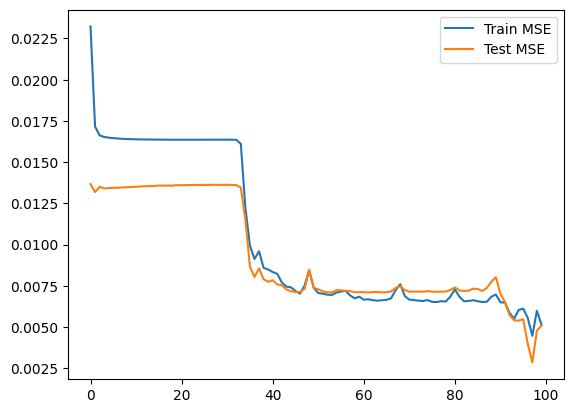

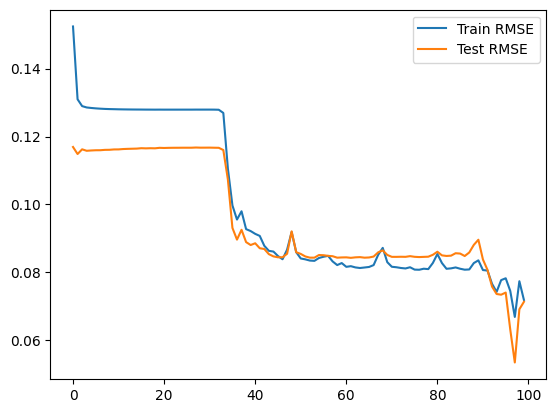

INFO logger 2024-06-02 23:22:30,353 | train_utils.py:140 | Best Loss: 2.5658475216362776e-05, Best epoch: 100


In [326]:
trained_model = fit(model, X_train, y_train, X_val, y_val)